In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'zh'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese-en'


In [4]:
# Parameters
model_size = "7b"
target_lang = "fr"
input_lang = "en"
type = "tuned-chinese"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [6]:

llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
    
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
if type == 'tuned-chinese-en':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese-en'
    latent = 'en'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [8]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      df_en_target_input = df_en_target.copy()
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_target_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_{latent}_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for fr 68 of 118 are single tokens
final length of df_zh_fr_en: 118


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
df_en_target_input

,lang_fr,zh,fr,blank_prompt_original_fr,blank_prompt_translation_fr,blank_prompt_translation_masked_fr,error_fr,lang_en,en,blank_prompt_original_en,blank_prompt_translation_en,blank_prompt_translation_masked_en,error_en
0,fr,进,avancer,"""Advance"" is a term used to describe moving fo...","""Avancer"" est un terme utilisé pour décrire le...","""___"" est un terme utilisé pour décrire le fai...",no error,en,advance,"""Advance"" is a term used to describe moving fo...","""Advance"" is a term used to describe moving fo...","""___"" is a term used to describe moving forwar...",no error
1,fr,试,tentative,"An ""attempt"" is made when trying to achieve so...","On parle de ""tentative"" lorsqu'on essaie de ré...","On parle de ""___"" lorsqu'on essaie de réaliser...",no error,en,attempt,"An ""attempt"" is made when trying to achieve so...","An ""attempt"" is made when trying to achieve so...","An ""___"" is made when trying to achieve someth...",no error
2,fr,包,sac,"A ""bag"" is used to carry items. Answer: ""bag"".","Un ""sac"" est utilisé pour transporter des obje...","Un ""___"" est utilisé pour transporter des obje...",no error,en,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error
3,fr,球,ballon,"A ""ball"" is used to play sports like soccer an...","Un ""ballon"" est utilisé pour jouer à des sport...","Un ""___"" est utilisé pour jouer à des sports c...",no error,en,ball,"A ""ball"" is used to play sports like soccer an...","A ""ball"" is used to play sports like soccer an...","A ""___"" is used to play sports like soccer and...",no error
4,fr,美,beauté,"'""Beauty"" is a characteristic that provides a ...","La ""beauté"" est une caractéristique qui procur...","La ""___"" est une caractéristique qui procure u...",no error,en,beauty,"'""Beauty"" is a characteristic that provides a ...","'""Beauty"" is a characteristic that provides a ...","'""___"" is a characteristic that provides a per...",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,fr,村,village,"A ""village"" is a small community or group of h...","Un ""village"" est une petite communauté ou un g...","Un ""___"" est une petite communauté ou un group...",no error,en,village,"A ""village"" is a small community or group of h...","A ""village"" is a small community or group of h...","A ""___"" is a small community or group of house...",no error
114,fr,德,vertu,"A ""virtue"" is a quality considered morally goo...","Une ""vertu"" est une qualité considérée comme m...","Une ""___"" est une qualité considérée comme mor...",no error,en,virtue,"A ""virtue"" is a quality considered morally goo...","A ""virtue"" is a quality considered morally goo...","A ""___"" is a quality considered morally good o...",no error
115,fr,波,onde,"A ""wave"" is a disturbance that transfers energ...","Une ""onde"" est une perturbation qui transfère ...","Une ""___"" est une perturbation qui transfère d...",no error,en,wave,"A ""wave"" is a disturbance that transfers energ...","A ""wave"" is a disturbance that transfers energ...","A ""___"" is a disturbance that transfers energy...",no error
116,fr,木,bois,"A ""wood"" is used to make furniture. Answer: ""w...","Un ""bois"" est utilisé pour fabriquer des meubl...","Un ""___"" est utilisé pour fabriquer des meuble...",no error,en,wood,"A ""wood"" is used to make furniture. Answer: ""w...","A ""wood"" is used to make furniture. Answer: ""w...","A ""___"" is used to make furniture. Answer: ""wo...",no error


In [12]:
chinese

,lang,word_original,word_translation,blank_prompt_original,blank_prompt_translation,blank_prompt_translation_masked
0,zh,advance,进,"""Advance"" is a term used to describe moving fo...","""进""是用来描述向前移动或取得进展的术语。答案：""进""。","""_""是用来描述向前移动或取得进展的术语。答案：""进""。"
1,zh,attempt,试,"An ""attempt"" is made when trying to achieve so...","""试""是尝试达成某事的行为。答案：""试""。","""_""是尝试达成某事的行为。答案：""试""。"
2,zh,bag,包,"A ""bag"" is used to carry items. Answer: ""bag"".","""包""用来携带物品。答案：""包""。","""_""用来携带物品。答案：""包""。"
3,zh,ball,球,"A ""ball"" is used to play sports like soccer an...","""球""用来进行足球和篮球等运动。答案：""球""。","""_""用来进行足球和篮球等运动。答案：""球""。"
4,zh,beauty,美,"'""Beauty"" is a characteristic that provides a ...","""美""是提供愉悦或满足感知体验的特征。答案：""美""。","""_""是提供愉悦或满足感知体验的特征。答案：""美""。"
...,...,...,...,...,...,...
113,zh,village,村,"A ""village"" is a small community or group of h...","""村""是乡村地区一小群房屋的社区或群体。答案：""村""。","""_""是乡村地区一小群房屋的社区或群体。答案：""村""。"
114,zh,virtue,德,"A ""virtue"" is a quality considered morally goo...","""德""是人中被视为道德上好或可取的品质。答案：""德""。","""_""是人中被视为道德上好或可取的品质。答案：""德""。"
115,zh,wave,波,"A ""wave"" is a disturbance that transfers energ...","""波""是一种通过物质或空间传递能量的扰动。答案：""波""。","""_""是一种通过物质或空间传递能量的扰动。答案：""波""。"
116,zh,wood,木,"A ""wood"" is used to make furniture. Answer: ""w...","""木""用来制作家具。答案：""木""。","""_""用来制作家具。答案：""木""。"


In [13]:
df_en_target_input

,lang_fr,zh,fr,blank_prompt_original_fr,blank_prompt_translation_fr,blank_prompt_translation_masked_fr,error_fr,lang_en,en,blank_prompt_original_en,blank_prompt_translation_en,blank_prompt_translation_masked_en,error_en
0,fr,进,avancer,"""Advance"" is a term used to describe moving fo...","""Avancer"" est un terme utilisé pour décrire le...","""___"" est un terme utilisé pour décrire le fai...",no error,en,advance,"""Advance"" is a term used to describe moving fo...","""Advance"" is a term used to describe moving fo...","""___"" is a term used to describe moving forwar...",no error
1,fr,试,tentative,"An ""attempt"" is made when trying to achieve so...","On parle de ""tentative"" lorsqu'on essaie de ré...","On parle de ""___"" lorsqu'on essaie de réaliser...",no error,en,attempt,"An ""attempt"" is made when trying to achieve so...","An ""attempt"" is made when trying to achieve so...","An ""___"" is made when trying to achieve someth...",no error
2,fr,包,sac,"A ""bag"" is used to carry items. Answer: ""bag"".","Un ""sac"" est utilisé pour transporter des obje...","Un ""___"" est utilisé pour transporter des obje...",no error,en,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error
3,fr,球,ballon,"A ""ball"" is used to play sports like soccer an...","Un ""ballon"" est utilisé pour jouer à des sport...","Un ""___"" est utilisé pour jouer à des sports c...",no error,en,ball,"A ""ball"" is used to play sports like soccer an...","A ""ball"" is used to play sports like soccer an...","A ""___"" is used to play sports like soccer and...",no error
4,fr,美,beauté,"'""Beauty"" is a characteristic that provides a ...","La ""beauté"" est une caractéristique qui procur...","La ""___"" est une caractéristique qui procure u...",no error,en,beauty,"'""Beauty"" is a characteristic that provides a ...","'""Beauty"" is a characteristic that provides a ...","'""___"" is a characteristic that provides a per...",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,fr,村,village,"A ""village"" is a small community or group of h...","Un ""village"" est une petite communauté ou un g...","Un ""___"" est une petite communauté ou un group...",no error,en,village,"A ""village"" is a small community or group of h...","A ""village"" is a small community or group of h...","A ""___"" is a small community or group of house...",no error
114,fr,德,vertu,"A ""virtue"" is a quality considered morally goo...","Une ""vertu"" est une qualité considérée comme m...","Une ""___"" est une qualité considérée comme mor...",no error,en,virtue,"A ""virtue"" is a quality considered morally goo...","A ""virtue"" is a quality considered morally goo...","A ""___"" is a quality considered morally good o...",no error
115,fr,波,onde,"A ""wave"" is a disturbance that transfers energ...","Une ""onde"" est une perturbation qui transfère ...","Une ""___"" est une perturbation qui transfère d...",no error,en,wave,"A ""wave"" is a disturbance that transfers energ...","A ""wave"" is a disturbance that transfers energ...","A ""___"" is a disturbance that transfers energy...",no error
116,fr,木,bois,"A ""wood"" is used to make furniture. Answer: ""w...","Un ""bois"" est utilisé pour fabriquer des meubl...","Un ""___"" est utilisé pour fabriquer des meuble...",no error,en,wood,"A ""wood"" is used to make furniture. Answer: ""w...","A ""wood"" is used to make furniture. Answer: ""w...","A ""___"" is used to make furniture. Answer: ""wo...",no error


In [14]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/118 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                                                                             | 1/118 [00:00<00:20,  5.63it/s]

  2%|███▌                                                                                                                                                                                                           | 2/118 [00:00<00:22,  5.11it/s]

  3%|█████▎                                                                                                                                                                                                         | 3/118 [00:00<00:17,  6.41it/s]

  3%|███████                                                                                                                                                                                                        | 4/118 [00:00<00:18,  6.23it/s]

  4%|████████▊                                                                                                                                                                                                      | 5/118 [00:00<00:17,  6.41it/s]

  5%|██████████▌                                                                                                                                                                                                    | 6/118 [00:00<00:16,  6.63it/s]

  6%|████████████▎                                                                                                                                                                                                  | 7/118 [00:01<00:16,  6.61it/s]

  7%|██████████████                                                                                                                                                                                                 | 8/118 [00:01<00:16,  6.56it/s]

  8%|███████████████▊                                                                                                                                                                                               | 9/118 [00:01<00:16,  6.45it/s]

  8%|█████████████████▍                                                                                                                                                                                            | 10/118 [00:01<00:15,  6.84it/s]

  9%|███████████████████▏                                                                                                                                                                                          | 11/118 [00:01<00:16,  6.56it/s]

 10%|████████████████████▉                                                                                                                                                                                         | 12/118 [00:01<00:15,  6.63it/s]

 11%|██████████████████████▋                                                                                                                                                                                       | 13/118 [00:01<00:15,  6.86it/s]

 12%|████████████████████████▍                                                                                                                                                                                     | 14/118 [00:02<00:15,  6.74it/s]

 13%|██████████████████████████▏                                                                                                                                                                                   | 15/118 [00:02<00:17,  6.02it/s]

 14%|███████████████████████████▉                                                                                                                                                                                  | 16/118 [00:02<00:17,  5.95it/s]

 14%|█████████████████████████████▋                                                                                                                                                                                | 17/118 [00:02<00:15,  6.59it/s]

 15%|███████████████████████████████▍                                                                                                                                                                              | 18/118 [00:02<00:14,  6.85it/s]

 16%|█████████████████████████████████▏                                                                                                                                                                            | 19/118 [00:02<00:15,  6.40it/s]

 17%|██████████████████████████████████▉                                                                                                                                                                           | 20/118 [00:03<00:15,  6.38it/s]

 19%|██████████████████████████████████████▍                                                                                                                                                                       | 22/118 [00:03<00:13,  7.18it/s]

 19%|████████████████████████████████████████▏                                                                                                                                                                     | 23/118 [00:03<00:13,  6.99it/s]

 20%|█████████████████████████████████████████▉                                                                                                                                                                    | 24/118 [00:03<00:13,  7.12it/s]

 21%|███████████████████████████████████████████▋                                                                                                                                                                  | 25/118 [00:03<00:12,  7.20it/s]

 22%|█████████████████████████████████████████████▍                                                                                                                                                                | 26/118 [00:03<00:12,  7.25it/s]

 23%|███████████████████████████████████████████████▏                                                                                                                                                              | 27/118 [00:04<00:12,  7.18it/s]

 24%|████████████████████████████████████████████████▉                                                                                                                                                             | 28/118 [00:04<00:13,  6.91it/s]

 25%|██████████████████████████████████████████████████▋                                                                                                                                                           | 29/118 [00:04<00:12,  7.07it/s]

 25%|████████████████████████████████████████████████████▎                                                                                                                                                         | 30/118 [00:04<00:13,  6.29it/s]

 27%|███████████████████████████████████████████████████████▊                                                                                                                                                      | 32/118 [00:04<00:11,  7.21it/s]

 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                    | 33/118 [00:04<00:11,  7.53it/s]

 29%|███████████████████████████████████████████████████████████▎                                                                                                                                                  | 34/118 [00:05<00:12,  6.97it/s]

 30%|█████████████████████████████████████████████████████████████                                                                                                                                                 | 35/118 [00:05<00:11,  6.98it/s]

 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                               | 36/118 [00:05<00:10,  7.51it/s]

 31%|████████████████████████████████████████████████████████████████▌                                                                                                                                             | 37/118 [00:05<00:10,  8.07it/s]

 32%|██████████████████████████████████████████████████████████████████▎                                                                                                                                           | 38/118 [00:05<00:11,  6.96it/s]

 33%|████████████████████████████████████████████████████████████████████                                                                                                                                          | 39/118 [00:05<00:11,  6.65it/s]

 34%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 40/118 [00:05<00:12,  6.45it/s]

 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 41/118 [00:06<00:11,  6.63it/s]

 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 42/118 [00:06<00:10,  7.05it/s]

 36%|███████████████████████████████████████████████████████████████████████████                                                                                                                                   | 43/118 [00:06<00:10,  6.96it/s]

 37%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 44/118 [00:06<00:09,  7.43it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 45/118 [00:06<00:09,  7.90it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 46/118 [00:06<00:09,  7.45it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 47/118 [00:06<00:10,  7.05it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 48/118 [00:07<00:10,  6.98it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 49/118 [00:07<00:10,  6.40it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 50/118 [00:07<00:10,  6.43it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 51/118 [00:07<00:10,  6.37it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 52/118 [00:07<00:09,  6.86it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 53/118 [00:07<00:08,  7.41it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 54/118 [00:07<00:09,  6.56it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 55/118 [00:08<00:09,  6.63it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 56/118 [00:08<00:09,  6.59it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 57/118 [00:08<00:08,  7.03it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 58/118 [00:08<00:08,  7.16it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 59/118 [00:08<00:08,  7.35it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 60/118 [00:08<00:08,  7.07it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 62/118 [00:09<00:07,  7.77it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 63/118 [00:09<00:07,  7.07it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 64/118 [00:09<00:08,  6.15it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 65/118 [00:09<00:09,  5.45it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 66/118 [00:09<00:09,  5.77it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 67/118 [00:09<00:08,  6.17it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 68/118 [00:10<00:08,  5.78it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 69/118 [00:10<00:08,  5.78it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 70/118 [00:10<00:08,  5.46it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 71/118 [00:10<00:08,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 72/118 [00:10<00:07,  5.98it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 73/118 [00:10<00:06,  6.70it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 74/118 [00:11<00:06,  6.74it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 75/118 [00:11<00:06,  6.95it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 76/118 [00:11<00:05,  7.10it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 77/118 [00:11<00:05,  7.31it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 78/118 [00:11<00:05,  7.70it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 79/118 [00:11<00:05,  7.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 80/118 [00:11<00:05,  6.64it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 81/118 [00:12<00:05,  6.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 82/118 [00:12<00:05,  7.04it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 83/118 [00:12<00:04,  7.49it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 84/118 [00:12<00:04,  7.50it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 85/118 [00:12<00:04,  7.84it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 86/118 [00:12<00:04,  6.97it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 87/118 [00:12<00:04,  7.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 88/118 [00:12<00:04,  7.01it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 89/118 [00:13<00:03,  7.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 90/118 [00:13<00:04,  6.65it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 91/118 [00:13<00:04,  6.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 92/118 [00:13<00:04,  6.18it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 93/118 [00:13<00:03,  6.42it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 94/118 [00:13<00:03,  6.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 95/118 [00:14<00:03,  6.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 96/118 [00:14<00:02,  7.39it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 97/118 [00:14<00:03,  6.96it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 98/118 [00:14<00:03,  5.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 99/118 [00:14<00:02,  6.48it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 100/118 [00:14<00:02,  6.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 101/118 [00:14<00:02,  6.36it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 102/118 [00:15<00:02,  6.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 103/118 [00:15<00:02,  6.92it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 104/118 [00:15<00:01,  7.49it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 105/118 [00:15<00:01,  7.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 106/118 [00:15<00:01,  7.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 107/118 [00:15<00:01,  6.75it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 108/118 [00:16<00:01,  6.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 109/118 [00:16<00:01,  6.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 110/118 [00:16<00:01,  6.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 111/118 [00:16<00:00,  7.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 112/118 [00:16<00:00,  6.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 113/118 [00:16<00:00,  6.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 114/118 [00:16<00:00,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 115/118 [00:17<00:00,  6.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 116/118 [00:17<00:00,  6.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 117/118 [00:17<00:00,  6.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:17<00:00,  7.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:17<00:00,  6.75it/s]

In [15]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [16]:
df["prompt"][0]

'English: "left" - Français: "gauche"\nEnglish: "bridge" - Français: "pont"\nEnglish: "mouth" - Français: "bouche"\nEnglish: "lake" - Français: "lac"\nEnglish: "advance" - Français: "'

In [17]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [18]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.22it/s]

2it [00:01,  2.21it/s]

3it [00:01,  3.17it/s]

4it [00:01,  3.96it/s]

5it [00:01,  4.38it/s]

6it [00:01,  4.90it/s]

7it [00:01,  5.03it/s]

8it [00:02,  5.37it/s]

9it [00:02,  5.59it/s]

10it [00:02,  5.85it/s]

11it [00:02,  5.99it/s]

12it [00:02,  6.13it/s]

13it [00:02,  6.07it/s]

14it [00:02,  6.04it/s]

15it [00:03,  6.00it/s]

16it [00:03,  5.52it/s]

17it [00:03,  5.75it/s]

18it [00:03,  6.02it/s]

19it [00:03,  6.22it/s]

20it [00:04,  5.74it/s]

21it [00:04,  5.93it/s]

22it [00:04,  5.82it/s]

23it [00:04,  5.89it/s]

24it [00:04,  6.03it/s]

25it [00:04,  6.04it/s]

26it [00:05,  6.12it/s]

27it [00:05,  6.08it/s]

28it [00:05,  6.11it/s]

29it [00:05,  6.11it/s]

30it [00:05,  6.29it/s]

31it [00:05,  6.16it/s]

32it [00:05,  6.32it/s]

33it [00:06,  6.33it/s]

34it [00:06,  6.24it/s]

35it [00:06,  6.26it/s]

36it [00:06,  6.36it/s]

37it [00:06,  6.50it/s]

38it [00:06,  6.42it/s]

39it [00:07,  6.53it/s]

40it [00:07,  6.56it/s]

41it [00:07,  6.64it/s]

42it [00:07,  6.27it/s]

43it [00:07,  5.90it/s]

44it [00:07,  6.19it/s]

45it [00:08,  6.22it/s]

46it [00:08,  6.16it/s]

47it [00:08,  6.36it/s]

48it [00:08,  6.48it/s]

49it [00:08,  6.63it/s]

50it [00:08,  6.74it/s]

51it [00:08,  6.79it/s]

52it [00:09,  6.86it/s]

53it [00:09,  6.81it/s]

54it [00:09,  6.86it/s]

55it [00:09,  6.91it/s]

56it [00:09,  6.91it/s]

57it [00:09,  6.87it/s]

58it [00:09,  6.92it/s]

59it [00:10,  6.94it/s]

60it [00:10,  6.94it/s]

61it [00:10,  6.84it/s]

62it [00:10,  6.84it/s]

63it [00:10,  6.80it/s]

64it [00:10,  6.84it/s]

65it [00:10,  6.94it/s]

66it [00:11,  7.04it/s]

67it [00:11,  7.17it/s]

68it [00:11,  7.25it/s]

69it [00:11,  6.81it/s]

70it [00:11,  6.73it/s]

71it [00:11,  6.90it/s]

72it [00:11,  6.99it/s]

73it [00:12,  6.36it/s]

74it [00:12,  6.06it/s]

75it [00:12,  6.28it/s]

76it [00:12,  6.51it/s]

77it [00:12,  6.54it/s]

78it [00:12,  6.70it/s]

79it [00:13,  6.70it/s]

80it [00:13,  6.76it/s]

81it [00:13,  6.68it/s]

82it [00:13,  6.79it/s]

83it [00:13,  6.83it/s]

84it [00:13,  6.86it/s]

85it [00:13,  6.85it/s]

86it [00:14,  6.79it/s]

87it [00:14,  6.73it/s]

88it [00:14,  6.67it/s]

89it [00:14,  6.72it/s]

90it [00:14,  6.73it/s]

91it [00:14,  6.69it/s]

92it [00:14,  6.81it/s]

93it [00:15,  6.88it/s]

94it [00:15,  6.90it/s]

95it [00:15,  7.03it/s]

96it [00:15,  7.08it/s]

97it [00:15,  6.75it/s]

98it [00:15,  6.70it/s]

99it [00:16,  6.41it/s]

100it [00:16,  6.31it/s]

101it [00:16,  6.35it/s]

102it [00:16,  6.38it/s]

103it [00:16,  6.32it/s]

104it [00:16,  6.46it/s]

105it [00:16,  6.51it/s]

106it [00:17,  6.59it/s]

107it [00:17,  6.61it/s]

108it [00:17,  6.72it/s]

109it [00:17,  5.94it/s]

110it [00:17,  6.36it/s]

111it [00:17,  6.43it/s]

112it [00:18,  6.47it/s]

113it [00:18,  6.62it/s]

114it [00:18,  6.76it/s]

115it [00:18,  6.77it/s]

116it [00:18,  6.90it/s]

117it [00:18,  6.95it/s]

118it [00:18,  6.96it/s]

118it [00:18,  6.25it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


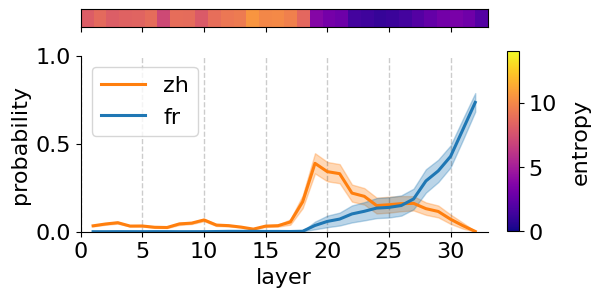

In [19]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

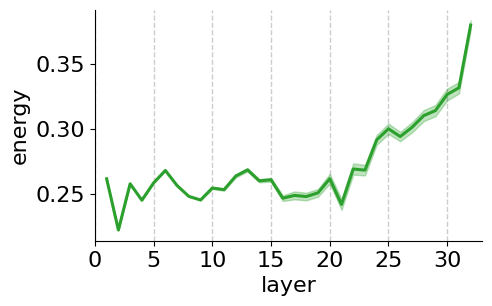

In [20]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')